# Graph Theory Algorithms with Neo4j and python

## Imports

In [5]:
from py2neo import Graph

In [6]:
from neo4j import GraphDatabase

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [8]:
import seaborn as sns
sns.set();
sns.color_palette("colorblind");

In [9]:
%matplotlib inline

In [10]:
from scipy import stats

## Conect to Neo4j

In [11]:
uri = 'bolt://neo4j-hdx:7687'

In [12]:
driver = GraphDatabase.driver(uri, auth=("neo4j", "test"))

In [13]:
graph = Graph(uri, auth=("neo4j", "test"))

Obtain list of all years with data available:

In [14]:
years_list = [rel for rel in graph.schema.relationship_types if rel.isdigit()]
years_list.sort()

## Centrality Algorithms

### Degree of centrality using a cypher query

This algorithm is often used as part of a global analysis where to calculate the minimum degree, maximum degree, mean degree and standard deviation across the whole graph.

https://neo4j.com/blog/graph-algorithms-neo4j-degree-centrality/

In [15]:
def degree_centrality_given_year(tx,year):
    return tx.run("MATCH (a:CountryYear) "
                  "WHERE a.year={0} "
                  "RETURN a.country as name, "
                  "size((a)-[:RESIDE_IN]->()) AS originates_from, "
                  "size((a)<-[:RESIDE_IN]-()) AS resides_in ".format(year))

In [16]:
year_D1 = 2017

In [17]:
with driver.session() as session:
    centrality_year = session.read_transaction(degree_centrality_given_year, year_D1).data()

In [18]:
def plot_centrality_given_year(centrality_year_list, year):
    
    f, axes = plt.subplots(2, 2, figsize=(15, 11), sharex=True);

    p1 = sns.distplot([data['originates_from'] for data in centrality_year_list], 
                 kde=False, color="darkturquoise", bins = 70, ax=axes[0,0])
    p1.set_title("Originates from:\n Histogram of Outbound relationships for CountryYear nodes in {0}".format(year));

    p2 = sns.distplot([data['resides_in'] for data in centrality_year_list], 
                 kde=False, color="royalblue", bins = 90, ax=axes[1,0])
    p2.set_title("Resides in:\n Histogram Inbound relationships for CountryYear nodes in {0}".format(year));

    p3 = sns.boxplot(x=[data['originates_from'] for data in centrality_year_list],
                     color="darkturquoise", ax=axes[0,1])
    p3.set_title("Originates from:\n Boxplot of Outbound relationships for CountryYear nodes in {0}".format(year));

    p4 = sns.boxplot(x=[data['resides_in'] for data in centrality_year_list], 
                     color="royalblue", ax=axes[1,1])
    p4.set_title("Resides in:\n Boxplot Inbound relationships for CountryYear nodes in {0}".format(year));

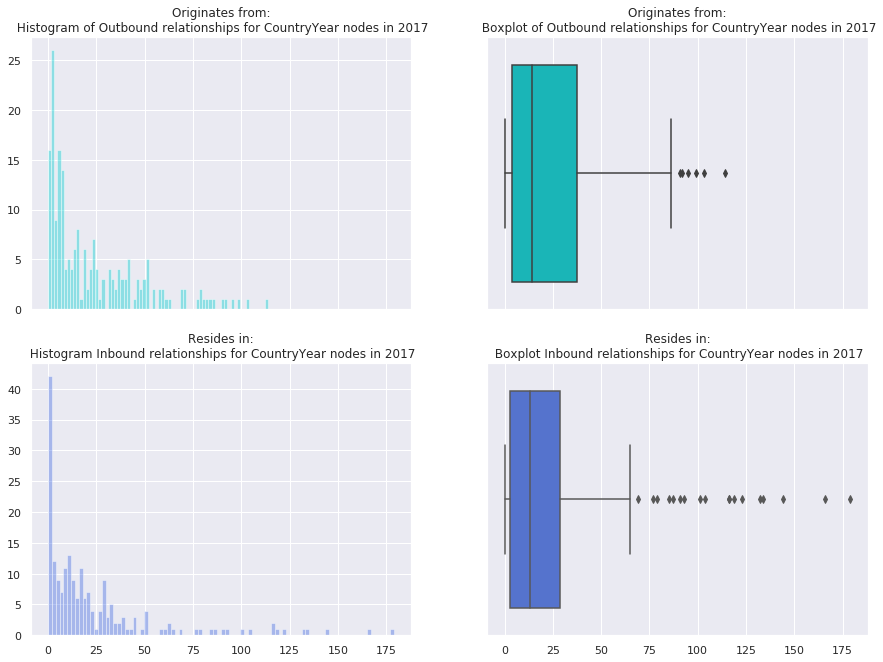

In [19]:
plot_centrality_given_year(centrality_year, year_D1)

In [20]:
stats.describe([data['originates_from'] for data in centrality_year])

DescribeResult(nobs=199, minmax=(0, 114), mean=23.954773869346734, variance=635.6191563880005, skewness=1.3383048262981498, kurtosis=1.178025401579693)

In [21]:
stats.describe([data['resides_in'] for data in centrality_year])

DescribeResult(nobs=199, minmax=(0, 179), mean=23.954773869346734, variance=1070.6797624486067, skewness=2.360237215121091, kurtosis=5.855756996958778)

Get the mean of centrality for all years in years_list:

In [24]:
with driver.session() as session:
    centrality_all_years = {}
    for year in years_list:
        centrality_all_years[year] = session.read_transaction(degree_centrality_given_year, year).data()

In [25]:
mean_centrality_all_years_originate ={}
mean_centrality_all_years_reside ={}

for key in centrality_all_years.keys():
    mean_centrality_all_years_originate[key] = stats.describe([data['resides_in'] for data in centrality_all_years[key]]).mean
    mean_centrality_all_years_reside[key] = stats.describe([data['originates_from'] for data in centrality_all_years[key]]).mean

In [26]:
def plot_mean_centrality_all_years(mean_centrality_all_years_list):
    plt.figure(figsize=(16,4))
    ax = sns.barplot(x=list(mean_centrality_all_years_list.keys()), 
                     y=list(mean_centrality_all_years_list.values()),
                     color="darkturquoise")
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    plt.xticks(rotation=45, ha='right')
    plt.title("Calculated Mean of Degree of Centrality for all years with data available");

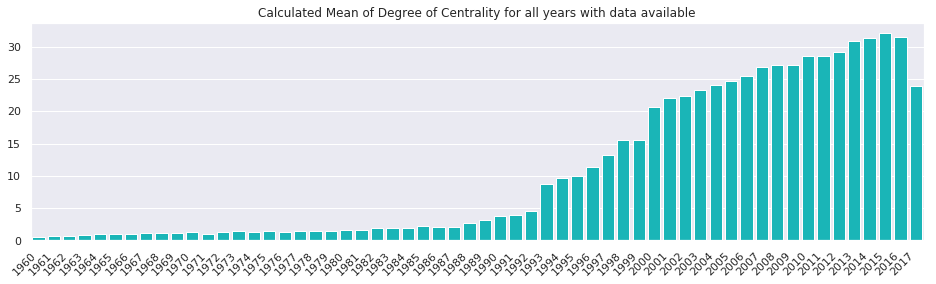

In [27]:
plot_mean_centrality_all_years(mean_centrality_all_years_originate)

### Degree Centrality Algorithm with "algo" package

Use Degree Centrality when attempting to analyze influence by looking at the number of incoming and outgoing relationships, or find the “popularity” of individ‐ ual nodes.

https://neo4j.com/docs/graph-algorithms/current/algorithms/degree-centrality/

In [28]:
def algo_degree_given_year(tx,year):
    return tx.run("CALL algo.degree( "
                  "'MATCH (n:CountryYear) WHERE n.year={0} RETURN id(n) AS id', "
                  "'MATCH (n)-[r:RESIDE_IN]->(m) RETURN id(n) AS source, id(m) AS target', "
                  "{{graph:'cypher', write: true, writeProperty: 'centrality'}})"
                  "YIELD nodes, loadMillis, computeMillis, writeMillis, write, writeProperty".format(year))

Include degree of centrality as property in nodes for all queried subgraphs (one per year):

In [29]:
with driver.session() as session:
    result_algo_degree = {}
    for year in years_list:
        result_algo_degree[year] = session.read_transaction(algo_degree_given_year, year).data()

In [30]:
result_algo_degree

{'1960': [{'nodes': 2,
   'loadMillis': 212,
   'computeMillis': 0,
   'writeMillis': 0,
   'write': True,
   'writeProperty': 'centrality'}],
 '1961': [{'nodes': 8,
   'loadMillis': 146,
   'computeMillis': 0,
   'writeMillis': 0,
   'write': True,
   'writeProperty': 'centrality'}],
 '1962': [{'nodes': 8,
   'loadMillis': 137,
   'computeMillis': 0,
   'writeMillis': 0,
   'write': True,
   'writeProperty': 'centrality'}],
 '1963': [{'nodes': 11,
   'loadMillis': 139,
   'computeMillis': 0,
   'writeMillis': 0,
   'write': True,
   'writeProperty': 'centrality'}],
 '1964': [{'nodes': 25,
   'loadMillis': 135,
   'computeMillis': 0,
   'writeMillis': 0,
   'write': True,
   'writeProperty': 'centrality'}],
 '1965': [{'nodes': 27,
   'loadMillis': 130,
   'computeMillis': 0,
   'writeMillis': 0,
   'write': True,
   'writeProperty': 'centrality'}],
 '1966': [{'nodes': 33,
   'loadMillis': 147,
   'computeMillis': 0,
   'writeMillis': 0,
   'write': True,
   'writeProperty': 'centrality

### Betweenness Centrality Algorithm with "algo" package

Use it to find bottlenecks, control points, and vulnerabilities.

https://neo4j.com/docs/graph-algorithms/current/algorithms/betweenness-centrality/

In [37]:
def algo_betweenness_given_year(tx,year):
    return tx.run("CALL algo.betweenness( "
                  "'MATCH (n:CountryYear) WHERE n.year={0} RETURN id(n) AS id', "
                  "'MATCH (n)-[r:RESIDE_IN]->(m) RETURN id(n) AS source, id(m) AS target', "
                  "{{graph:'cypher', write: true, writeProperty: 'betweenness'}}) "
                  "YIELD nodes, minCentrality, maxCentrality, sumCentrality, loadMillis, computeMillis, writeMillis".format(year))

Include betweenness as property in nodes for all queried subgraphs (one per year):

In [38]:
with driver.session() as session:
    result_algo_betweenness = {}
    for year in years_list:
        result_algo_betweenness[year] = session.read_transaction(algo_betweenness_given_year, year).data()

In [34]:
result_algo_betweenness

{'1960': [{'nodes': 2,
   'minCentrality': -1.0,
   'maxCentrality': -1.0,
   'sumCentrality': -1.0,
   'loadMillis': 222,
   'computeMillis': 0,
   'writeMillis': 0}],
 '1961': [{'nodes': 8,
   'minCentrality': -1.0,
   'maxCentrality': -1.0,
   'sumCentrality': -1.0,
   'loadMillis': 147,
   'computeMillis': 0,
   'writeMillis': 0}],
 '1962': [{'nodes': 8,
   'minCentrality': -1.0,
   'maxCentrality': -1.0,
   'sumCentrality': -1.0,
   'loadMillis': 139,
   'computeMillis': 0,
   'writeMillis': 0}],
 '1963': [{'nodes': 11,
   'minCentrality': -1.0,
   'maxCentrality': -1.0,
   'sumCentrality': -1.0,
   'loadMillis': 133,
   'computeMillis': 0,
   'writeMillis': 0}],
 '1964': [{'nodes': 25,
   'minCentrality': -1.0,
   'maxCentrality': -1.0,
   'sumCentrality': -1.0,
   'loadMillis': 133,
   'computeMillis': 0,
   'writeMillis': 0}],
 '1965': [{'nodes': 27,
   'minCentrality': -1.0,
   'maxCentrality': -1.0,
   'sumCentrality': -1.0,
   'loadMillis': 141,
   'computeMillis': 0,
   'wr

## Comunity Detection Algorithms

Algorithms to evaluate how a group is clustered or partitioned

### Strongly Connected Components algorithm with "algo" package

Finds sets of connected nodes in a directed graph where each node is reachable in both directions from any other node in the same set. It is often used early in a graph analysis process to help get an idea of how the graph is structured

https://neo4j.com/docs/graph-algorithms/current/algorithms/strongly-connected-components/

In [ ]:
def algo_scc_given_year(tx,year):
    return tx.run("CALL algo.scc( "
                  "'MATCH (n:CountryYear) WHERE n.year={0} RETURN id(n) AS id', "
                  "'MATCH (n)-[r:RESIDE_IN]->(m) RETURN id(n) AS source, id(m) AS target', "
                  "{{graph:'cypher', write: true, writeProperty:'partition_scc'}}) "
                  "YIELD loadMillis, computeMillis, writeMillis, setCount, maxSetSize, minSetSize".format(year))

Include partition_scc as property in nodes for all queried subgraphs (one per year):

In [ ]:
with driver.session() as session:
    result_algo_scc = {}
    for year in years_list:
        result_algo_scc[year] = session.read_transaction(algo_scc_given_year, year).data()

### Louvain algorithm with "algo" package

Algorithm for detecting communities in networks

https://neo4j.com/docs/graph-algorithms/current/algorithms/louvain/

In [ ]:
def algo_louvain_given_year(tx,year):
    return tx.run("CALL algo.louvain( "
                  "'MATCH (n:CountryYear) WHERE n.year={0} RETURN id(n) AS id', "
                  "'MATCH (n)-[r:RESIDE_IN]->(m) RETURN id(n) AS source, id(m) AS target , r.affected_total as weight', "
                  "{{graph:'cypher', write: true, writeProperty: 'community_louvain', weightProperty:'weight' }})"
                  "YIELD nodes, communityCount, iterations, loadMillis, computeMillis, writeMillis".format(year))

Include community_louvain as property in nodes for all queried subgraphs (one per year):

In [ ]:
with driver.session() as session:
    result_algo_louvain = {}
    for year in years_list:
        result_algo_louvain[year] = session.read_transaction(algo_louvain_given_year, year).data()